In [2]:
import numpy as np
from numpy.random import seed
seed(440232650)
from tensorflow import set_random_seed
set_random_seed(440232650)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import tensorflow
warnings.filterwarnings('ignore') 
import os, random, cv2, h5py
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import np_utils
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s188/sarah_envir

In [3]:
import segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

#from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [123]:
from albumentations import (
    Compose,
    HorizontalFlip,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [5]:
mask_path = 'Masks_cat_4/Val'
images_path = 'Images/example'

In [137]:
aug = Compose([OneOf([
        ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03),
        GridDistortion(p=1, border_mode=0, value=5)], p=0.8),
    CLAHE(p=0.8),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

In [172]:
def visualize(image, mask, original_image=None, original_mask=None, save=False):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image, cmap='gray')
        plt.axis('off')
        ax[1].imshow(mask, cmap='plasma')
        
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap='gray')
        ax[0, 0].set_title('Original Image', fontsize=fontsize)
        ax[0, 0].axis('off')
        
        ax[1, 0].imshow(original_mask, cmap='plasma')
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)
        ax[1, 0].axis('off')
        
        ax[0, 1].imshow(image, cmap='gray')
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)
        ax[0, 1].axis('off')
        
        ax[1, 1].imshow(mask, cmap='plasma')
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        ax[1, 1].axis('off')
        
    if save == True:
        
        f.savefig('Figures/augmentationexample1.png')

In [8]:
n=os.listdir(images_path)

In [173]:
image = cv2.imread(os.path.join(images_path,n[0]), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(mask_path,n[0]), cv2.IMREAD_GRAYSCALE)

In [112]:
aug = GridDistortion(p=0.8, border_mode=0, value=5)

In [183]:
augmented = aug(image=image, mask=mask)

image_aug = augmented['image']
mask_aug = augmented['mask']

In [182]:
aug = Compose([OneOf([
        ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03),
        GridDistortion(p=0, border_mode=0, value=5)], p=1),
    CLAHE(p=0.8),
    HorizontalFlip(p=1),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

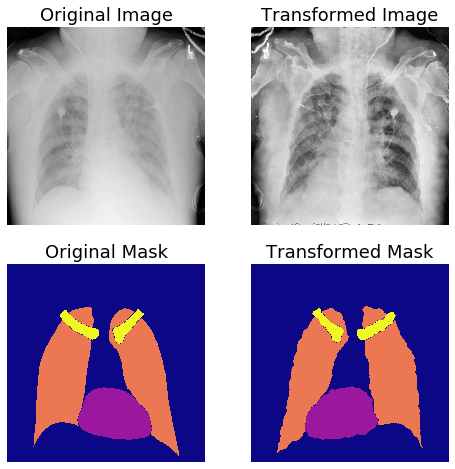

In [185]:
visualize(image_aug, mask_aug, original_image=image, original_mask=mask, save=True)

In [145]:
aug1 = ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03)
aug1 = aug1(image=image, mask=mask)
img1 = aug1['image']
mask1 = aug1['mask']

aug2 = GridDistortion(p=1, border_mode=0, value=5)
aug2 = aug2(image=image, mask=mask)
img2 = aug2['image']
mask2 = aug2['mask']

aug3 = CLAHE(p=1)
aug3 = aug3(image=image, mask=mask)
img3 = aug3['image']
mask3 = aug3['mask']

aug4 = HorizontalFlip(p=1)
aug4 = aug4(image=image, mask=mask)
img4 = aug4['image']
mask4 = aug4['mask']

aug5 = RandomBrightnessContrast(p=1)
aug5 = aug5(image=image, mask=mask)
img5 = aug5['image']
mask5 = aug5['mask']

aug6 = RandomGamma(p=1)
aug6 = aug6(image=image, mask=mask)
img6 = aug6['image']
mask6 = aug6['mask']

(-0.5, 1023.5, 1023.5, -0.5)

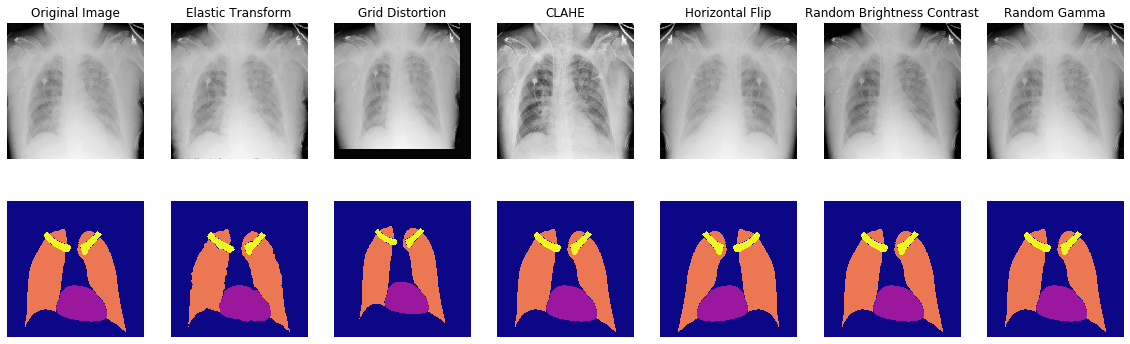

In [151]:
f, ax = plt.subplots(2, 7, figsize=(20, 6))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[1, 0].imshow(mask, cmap='plasma')
ax[1, 0].axis('off')

ax[0, 1].imshow(img1, cmap='gray')
ax[0, 1].set_title('Elastic Transform')
ax[0, 1].axis('off')

ax[1, 1].imshow(mask1, cmap='plasma')
ax[1, 1].axis('off')

ax[0, 2].imshow(img2, cmap='gray')
ax[0, 2].set_title('Grid Distortion')
ax[0, 2].axis('off')

ax[1, 2].imshow(mask2, cmap='plasma')
ax[1, 2].axis('off')

ax[0, 3].imshow(img3, cmap='gray')
ax[0, 3].set_title('CLAHE')
ax[0, 3].axis('off')

ax[1, 3].imshow(mask3, cmap='plasma')
ax[1, 3].axis('off')

ax[0, 4].imshow(img4, cmap='gray')
ax[0, 4].set_title('Horizontal Flip')
ax[0, 4].axis('off')

ax[1, 4].imshow(mask4, cmap='plasma')
ax[1, 4].axis('off')

ax[0, 5].imshow(img5, cmap='gray')
ax[0, 5].set_title('Random Brightness Contrast')
ax[0, 5].axis('off')

ax[1, 5].imshow(mask5, cmap='plasma')
ax[1, 5].axis('off')

ax[0, 6].imshow(img6, cmap='gray')
ax[0, 6].set_title('Random Gamma')
ax[0, 6].axis('off')

ax[1, 6].imshow(mask6, cmap='plasma')
ax[1, 6].axis('off')